In [4]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import gym 

# tqdm is a nice tool for seeing how long a loop will take to run
# You can install it using pip
from tqdm import tqdm

%matplotlib inline

# Gridding Continuous State Spaces.

So far in class, we have mainly focued on Markov decision processes with a finite number of states. However, in many 


A simple strategy that actually works pretty well in low-dimensional state spaces is gridding. Specifically, we partition the state space into a collection of boxes and then assign a number to each box (a grid cell). In two dimensions, a gridding would look something like: 

|   |   |   |
|---|---|---|
| 0 | 1 | 2 |
| 3 | 4 | 5 |
| 6 | 7 | 8 | 
| 9 | 10 | 11 |


Here we have a $3\times 4$ grid. 

To use a grid for reinforcement learning, we write a function that takes continuous states and maps them to their corresponding grid cells. Then we run our finite MDP reinforcement learning algorithms. 

Code to map continuous vectors to grid cells is given below. Note, this code specifies lower bounds, upper bounds, and the number of cells in each dimension. 

In [5]:
def gridIndex(x,LB,UB,N):
    """
    This code is used to compute the grid index of a particular state
    
    Usage:
    i = gridIndex(x,LB,UB,N)
    
    Inputs:
    x - an array of numbers
    LB - an array of lower bounds for each coordinate of x
    UB - an array of upper bounds for each coordinate of x
    N - an array of integers defining the number of grid cells of each coordinate of x 
    
    * Since x contains 4 tuples(position, velocity...), so N should've 4 integers that how many grid cells for each tuple.
    
    """
    
    numel = np.prod(N) 

    x = np.clip(x,LB,UB)                                       # set boundery LB, UB for each tuples in x(-array)
    mi = np.floor((x-LB) * N/(UB-LB))                          # floor-towards-zero > get integer
    i = np.ravel_multi_index(np.array(mi,dtype=int),N)         # make mi to array/function get index of grid
    return i

# The Cart-Pole Environment in OpenAI gym

The cart-pole environment in OpenAI gym focuses on the problem of balancing a pendulum on top of a cart. It is a simpler version of the problem we solved via MPC in Homework 2, as the pendulum starts upright, rather than being swung up from the bottom.

Another major difference between the OpenAI version and the one we used earlier is that the OpenAI system has only two allowable actions, whereas in Homework 2, we could apply arbitrary forces.

So, this system has a continuous state space with $4$ dimensions and binary actions. In this homework we will grid the state space and apply classical RL algorithms as though the grid cells were the states.

A simulation of the Cart-Pole system with random inputs is shown below. At each step, we recieve a reward of $1$ if the pendulum has not yet fallen. So, the total reward of an episode is the number of steps we manage to keep the pendulum upright.


# Cart-Pole State Space

The state space of the cart-pole system has coordinates given by:
* Cart position
* Cart velocity
* Pendulum angle
* Pendulum angular velocity

Note that the cart position and pendulum angle are bounded to compact regions, but the cart velocity and pendulum angular velocity are effectively unbounded:

In [6]:
env = gym.make('CartPole-v0')
StateSpace = env.observation_space           # 4 numbers for 4 tuples, where 2 velocity is extremely big                     
print('Lower Bounds on States')
print(StateSpace.low)
print('Upper Bounds on States')
print(StateSpace.high)

Lower Bounds on States
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Upper Bounds on States
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


To get a useful gridding of the state space, our grid needs to have more reasonable bounds on the velocity variables. In my tests, I used bounds or $\pm 10$ for both, and it worked fine. 

(Note: The gridding code above first clips the vector $x$ to ensure $\mathrm{LB} \le x \le \mathrm{UB}$ entrywise. So, if your velocities ever exceeded the bounds you choose, they will just get mapped to the nearest grid cell.)

# Question 1

Implement the SARSA algorithm from the Sutton and Barto text for this problem. 

Plot the total rewards in each of the episodes as shown above. Note that the system stops any time the pendulum has been upright for $200$ steps, so the maximum reward is $200$.



A wide variety of trade-offs and issues arise, which you should explore while coding.

* The number of cells to put in each dimension. A large number of cells can lead to more precise measurement, and thus more precise control. However, this leads to a large state space, and so getting good $Q$ estimates will take longer. 
* The learning rate, $\alpha$, will typically be some number around $0.1$ or smaller. Larger learning rates will usually cause faster learning at first, then improvement also slows down rapidly. Smaller learning rates usually give slower initial learning, but eventually outperform controls learned with higher rates. 
* If using $\epsilon$-greedy, $\epsilon$ is usually a smaller number, $0.1$ or smaller. Similar issues with the learning rate arise. 
* The discount factor is usually set to something fairly large, like $\gamma = .9$ or higher. Larger values place greater importance on the future, which is helpful when actions at one point in time strongly influence the state several steps into the future. 

**Notes:**
Using the gridding method, I managed to get the system to hit the max reward most of the time after a few thousand episodes. My solution never works perfectly because I am using $\epsilon$-greedy, and I am keeping $\epsilon$ fixed. 

Just try to get it to work pretty well. Don't worry about tuning the parameters to make it work perfectly.



100%|██████████| 5000/5000 [00:12<00:00, 393.26it/s]


Training Complete! 


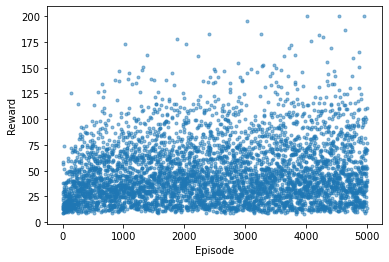

In [8]:
################################### SARSA ####################################
## Parameters
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.1
render = False

## Algorithm setup
env = gym.make('CartPole-v0')                           # env : openAI gym unified RL environment interface
NumEpisodes = 5000                                      # run for n episodes
Rewards = []                                            # track rewards of all episodes
LB = np.array([-5,-10,-4,-10])                     
UB = np.array([5,10,4,10])
N = (40,30,40,30)                                      
numel = np.prod(N)                                      # number of N elements' product
Q = np.zeros((N[0]*N[1]*N[2]*N[3],2))                   # initialize Q(s, a) / s:row, a:col

## Algorithm of TD policy evaluation
for ep in tqdm(range(NumEpisodes)):                     
    
    ## Initialize S
    done = False    
    R = 0                                               # R will hold the total accumulated reward
    s = env.reset()                                     # initialize a random state, current state s
    index = gridIndex(s,LB, UB, N)                      # index of perticular state, used in Q-row
    if render:
        env.render()                                    # visualize environment
        
    ## On-policy act greedy, since greater chance to " > EPSILON ", choose a from s (by epsilon-greedy)
    random = rnd.randn()                             
    if random > EPSILON:                                # exploit same policy
        A = np.argmax(Q[index,:])                       # current_A = argmax Q(current_s,arbitrary_a)
    else:                                               # explore new policy
        A = rnd.randint(2)                              # give random action A = 0 or 1
        
    ## loop for iteration in every episode
    while not done:
        
        ## Take action A to observe S' & immediate reward r
        s_next,r,done,info = env.step(A)                         
        index_next = gridIndex(s_next,LB, UB, N)                 

        ## On-policy act greedy, since greater chance to " > EPSILON ", choose a from s (by epsilon-greedy)
        random = rnd.randn()                             # choose a from s (by epsilon-greedy)        
        if random > EPSILON:
            A_next = np.argmax(Q[index,:])               # next_A = argmax Q(current_s,arbitrary_a)
            
        else:
            A_next = rnd.randint(2)
                
        ## Policy iteration of SARSA
        Q[index,A] = Q[index,A] + ALPHA*(r + GAMMA*Q[index_next,A_next] - Q[index,A])
        
        
        index = index_next                               # S <- S'
        A = A_next                                       # A <- A'
        R = r+R                                          # update the total reward 
            
        if render:
            env.render()
   
    env.close()
    Rewards.append(R)


## Plot the rewards
if done:
    print("Training Complete! ")
    plt.plot(Rewards,'.',alpha=.5)
    plt.xlabel('Episode')
    plt.ylabel('Reward')                            # Total rewards in one episode

# Question 2

Implement the Q-learning algorithm from the Sutton and Barto text for this problem. 

Plot the total rewards in each of the episodes as shown above. 

All of the comments from the first problem are still true when using $Q$-learning. Your performence will likely be fairly similar as well.



100%|██████████| 5000/5000 [00:12<00:00, 405.62it/s]


Training Complete! 


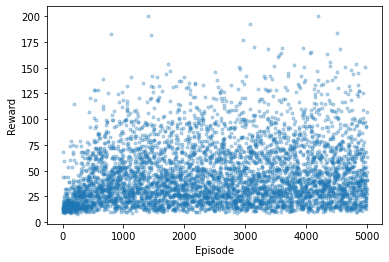

In [9]:
################################### Q-Learning ####################################
## Parameters
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.1
render = False

## Algorithm setup
env = gym.make('CartPole-v0')                      
NumEpisodes = 5000
Rewards = []                                       
LB = np.array([-5,-10,-4,-10])                     
UB = np.array([5,10,4,10])
N = (40,30,40,30)                                      
numel = np.prod(N)                                 
Q = np.zeros((N[0]*N[1]*N[2]*N[3],2))              

## Algorithm of TD policy evaluation
for ep in tqdm(range(NumEpisodes)):                       
    
    ## Initialize S
    done = False    
    R = 0                                          
    s = env.reset()                                
    index = gridIndex(s,LB, UB, N)                 
    if render:
        env.render()                               

    ## loop for iteration in every episode
    while not done:

        ## Off-policy act greedy, since greater chance to " > EPSILON ", choose a from s (by epsilon-greedy)
        random = rnd.randn()                             
        if random > EPSILON:                           
            A = np.argmax(Q[index_next,:])                    
        else:                                          
            A = rnd.randint(2)                         
        
        ## Take action A to observe S' & immediate reward r
        s_next,r,done,info = env.step(A)                         
        index_next = gridIndex(s_next,LB, UB, N)                 
        
        # In Q-learning equation: max Q(s',a*) = Q(s',pi(s')), where pi(s')=argmax Q(s',a)
        pi = np.argmax(Q[index_next,:])                                              
        Q[index,A] = Q[index,A] + ALPHA*(r + GAMMA*Q[index_next,pi] - Q[index,A])
        
        
        index = index_next
        R = r+R                                    
            
        if render:
            env.render()
   
    env.close()
    Rewards.append(R)


## Plot the rewards
if done:
    print("Training Complete! ")
    plt.plot(Rewards,'.',alpha=.3)
    plt.xlabel('Episode')
    plt.ylabel('Reward')                            # Total rewards in one episode